In [1]:
# ======================================================================
# TA-10 SIMULASI SISTEM DINAMIS DENGAN RK4
# Model: Pertumbuhan Kumulatif Views Trending YouTube (CAvideos.csv)
# ======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ==============================================================
# 1. LOAD DATASET
# ==============================================================

df = pd.read_csv("CAvideos.csv")
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


In [3]:
# ==============================================================
# 2. PREPROCESSING TIME-SERIES
# ==============================================================

# Total views per trending date
ts = df.groupby('trending_date')['views'].sum().sort_index().reset_index()

# Buat indeks waktu t = 0,1,2,...
ts['t'] = range(len(ts))

# Hitung kumulatif
ts['cum_views'] = ts['views'].cumsum()

# Konversi ke numpy
y = ts['cum_views'].astype(float).values
t = ts['t'].astype(float).values

# Normalisasi (0–1)
y_max = y.max()
y_norm = y / y_max

print("Panjang time-series:", len(y))
print("Nilai awal:", y_norm[0])
print("Nilai akhir:", y_norm[-1])

Panjang time-series: 205
Nilai awal: 0.004771247333275767
Nilai akhir: 1.0


In [4]:
# ==============================================================
# 3. DEFINISI MODEL ODE LOGISTIK
# ==============================================================

def logistic_rhs(t, C, r):
    """Persamaan logistik: dC/dt = r*C*(1 - C)"""
    return r * C * (1 - C)

In [5]:
# ==============================================================
# 4. IMPLEMENTASI RK4 MANUAL
# ==============================================================

def rk4_logistic(t0, C0, h, n_steps, r):
    """Solver RK4 untuk ODE logistik 1 variabel."""
    t = t0
    C = C0
    t_list = [t]
    C_list = [C]

    for _ in range(n_steps):
        k1 = logistic_rhs(t, C, r)
        k2 = logistic_rhs(t + 0.5*h, C + 0.5*h*k1, r)
        k3 = logistic_rhs(t + 0.5*h, C + 0.5*h*k2, r)
        k4 = logistic_rhs(t + h,     C + h*k3,     r)

        C = C + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        t = t + h

        t_list.append(t)
        C_list.append(C)

    return np.array(t_list), np.array(C_list)

In [6]:
# ==============================================================
# 5. PARAMETER TUNING (GRID SEARCH UNTUK r)
# ==============================================================

def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

def simulate(r):
    _, C_sim = rk4_logistic(0, y_norm[0], 1.0, len(t)-1, r)
    return C_sim

candidate_rs = np.linspace(0.03, 0.07, 41)
best_r = None
best_err = 1e9

for r in candidate_rs:
    C_sim = simulate(r)
    err = rmse(C_sim, y_norm)
    if err < best_err:
        best_err = err
        best_r = r

print("Best r =", best_r)
print("Best Normalized RMSE =", best_err)
print("Best RMSE (real views) =", best_err * y_max)

Best r = 0.05
Best Normalized RMSE = 0.13589776562830216
Best RMSE (real views) = 6372514637.77515


In [7]:
# ==============================================================
# 6. SIMULASI DENGAN PARAMETER TERBAIK
# ==============================================================

t_sim, C_sim = rk4_logistic(0, y_norm[0], 1.0, len(t)-1, best_r)

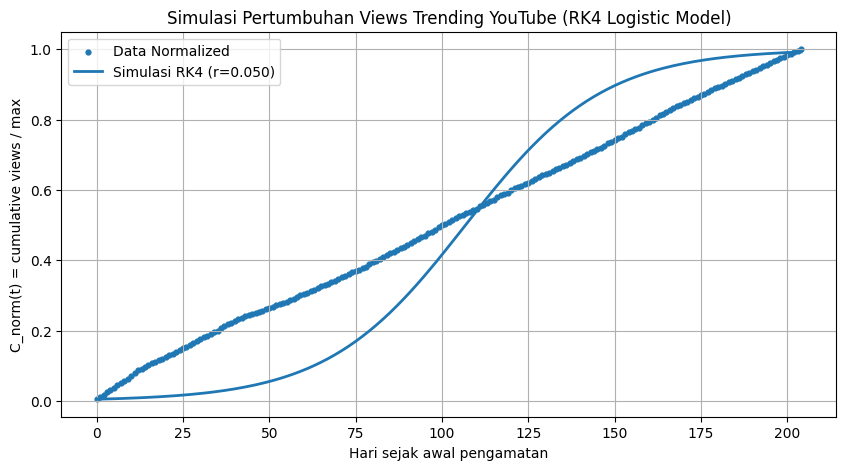

In [8]:
# ==============================================================
# 7. VISUALISASI DATA VS SIMULASI
# ==============================================================

plt.figure(figsize=(10,5))
plt.scatter(t, y_norm, label="Data Normalized", s=12)
plt.plot(t_sim, C_sim, label=f"Simulasi RK4 (r={best_r:.3f})", linewidth=2)
plt.xlabel("Hari sejak awal pengamatan")
plt.ylabel("C_norm(t) = cumulative views / max")
plt.title("Simulasi Pertumbuhan Views Trending YouTube (RK4 Logistic Model)")
plt.legend()
plt.grid(True)
plt.show()